# **Credit Card Default Prediction**

# **Introduction**

> This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

**There are 25 variables:**

> ID: ID of each client

> LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

> SEX: Gender (1=male, 2=female)

> EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

> MARRIAGE: Marital status (1=married, 2=single, 3=others)

> AGE: Age in years

> PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)

> PAY_2: Repayment status in August, 2005 (scale same as above)

> PAY_3: Repayment status in July, 2005 (scale same as above)

> PAY_4: Repayment status in June, 2005 (scale same as above)

> PAY_5: Repayment status in May, 2005 (scale same as above)

> PAY_6: Repayment status in April, 2005 (scale same as above)

> BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

> BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

> BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

> BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

> BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

> BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

> PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

> PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

> PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

> PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

> PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

> PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

> default.payment.next.month: Default payment (1=yes, 0=no)

**Objective:**
> The primary objective of this project is to leverage machine learning to predict whether a credit card user is likely to default on their payments. By evaluating past financial behaviors and patterns, we aim to provide credit decisions that are both responsible and sustainable.

In [42]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB


In [43]:
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na is deprecated")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.use_inf_as_na', True)

# **EDA & Data Preprocessing**

In [44]:
#Load the dataset
path =  "C:\\Users\\Skouza\\Desktop\\ML projects\\1-1-Default of Credit Card Clients\\UCI_Credit_Card.csv"
df=pd.read_csv(path)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [45]:
# Drop the 'ID' column
df.drop(columns=['ID'], inplace=True)

In [46]:
# rename to simplify
df.rename(columns={"default.payment.next.month": "def_pay",
                    'PAY_0': 'PAY_1'}, inplace=True)

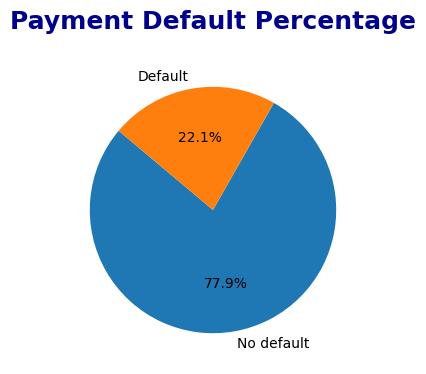

In [47]:
# Analyze the distribution of the target variable 'def_pay'
label_counts = df['def_pay'].map({0: 'No default', 1: 'Default'}).value_counts()
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Payment Default Percentage', fontsize=18, fontweight='bold', color='darkblue', pad=20)
plt.show()

> The percentage of defaulters in the data is 22.12 %
     --> The data is unbalanced 

### categorical features

In [48]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# Check unique values for each categorical feature
for feature in categorical_features:
    print(f"Unique values in {feature}: {df[feature].unique()}")

Unique values in SEX: [2 1]
Unique values in EDUCATION: [2 1 3 5 4 6 0]
Unique values in MARRIAGE: [1 2 3 0]


In [49]:
# changing labels 0,5,6 to 4 which represent other category
df['EDUCATION'] = df['EDUCATION'].apply(lambda x: 4 if x in [0, 5, 6] else x)

In [50]:
# replacing 0 to 3
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

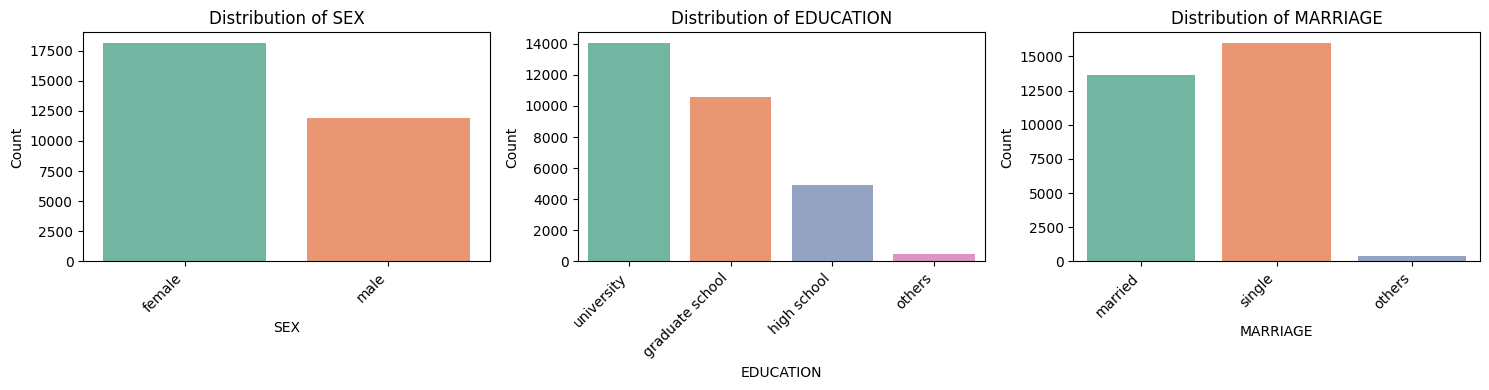

In [51]:
df_cat = df.copy()
df_cat.replace({'SEX': {1 : 'male', 2 : 'female'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)

plt.figure(figsize=(15, 4))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i) 
    sns.countplot(data=df_cat, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Numerical variable

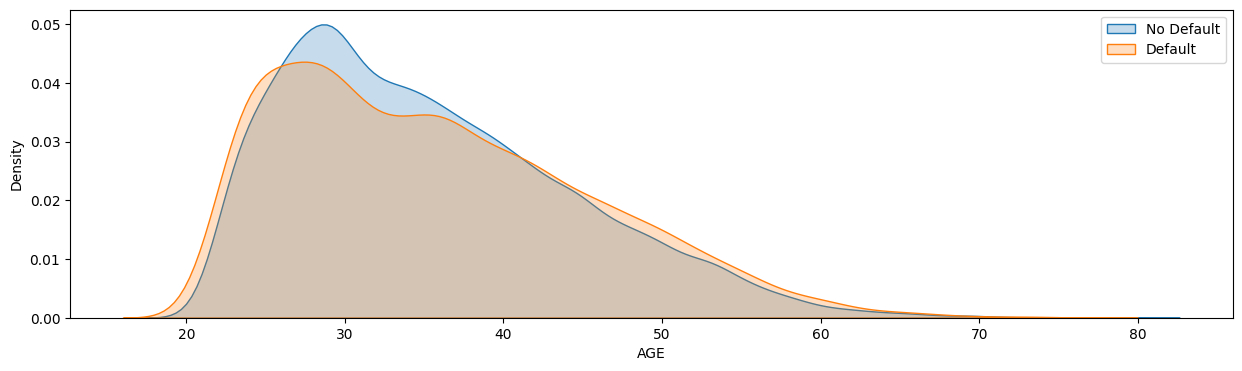

In [52]:
#Age
plt.figure(figsize=(15,4))
sns.kdeplot(df.loc[(df['def_pay'] == 0), 'AGE'], label = 'No Default', fill = True)
sns.kdeplot(df.loc[(df['def_pay'] == 1), 'AGE'], label = 'Default', fill = True)
plt.legend()
plt.show()

> -> The age group between 20 to 30 years old appears to have a higher propensity for defaults.

> -> Individuals aged between 20 and 25, as well as those above 50, are more prone to default on their credit card payments. In contrast, individuals within other age ranges show lower tendencies for default.

> The "PAY_n" variables show how many months a payment is late. A value of "-1" meaning the payment was made on time according to the document. However, the meaning of "-2" and "0" is not clear. 

> To make things clearer, it would be a good idea to consider "on-time payment" as 0.

In [53]:
#PAY_X
pay_x_fts = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for feature in pay_x_fts:
    print(f"Unique values in {feature}: {df[feature].unique()}")

Unique values in PAY_1: [ 2 -1  0 -2  1  3  4  8  7  5  6]
Unique values in PAY_2: [ 2  0 -1 -2  3  5  7  4  1  6  8]
Unique values in PAY_3: [-1  0  2 -2  3  4  6  7  1  5  8]
Unique values in PAY_4: [-1  0 -2  2  3  4  5  7  6  1  8]
Unique values in PAY_5: [-2  0 -1  2  3  5  4  7  8  6]
Unique values in PAY_6: [-2  2  0 -1  3  6  4  7  8  5]


In [54]:
def replace_to_zero(col):
    fil = (df[col] == -2) | (df[col] == -1) | (df[col] == 0)
    df.loc[fil, col] = 0

for i in ['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    replace_to_zero(i)

In [55]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,6))
    for i, var_name in enumerate(variables):
        row = i // n_cols
        col = i % n_cols
        sns.histplot(data=df, x=var_name, bins=n_bins, ax=axes[row, col])
        axes[row, col].set_title(var_name)
    fig.tight_layout()
    plt.show()

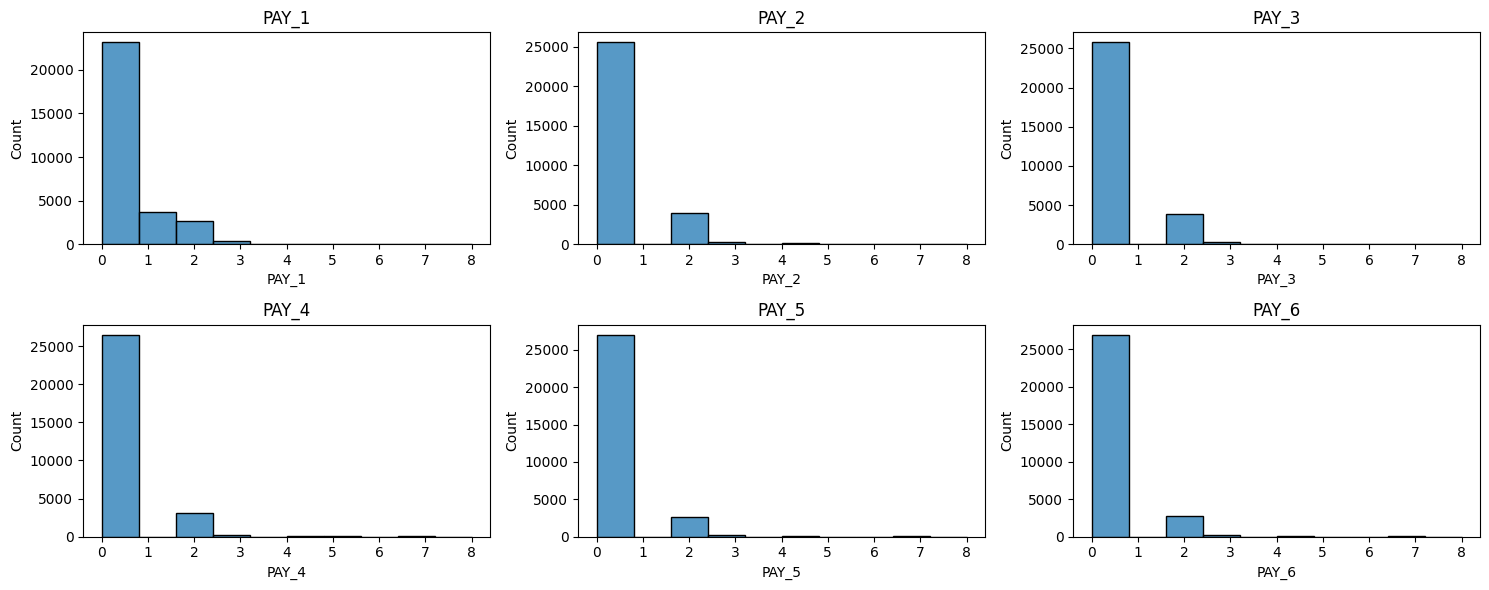

In [56]:
late = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 2, 3, 10)

> Most customers are duly paying their credit card bills. And it's clear that their likelihood of default are much lower than the rest(next graph).

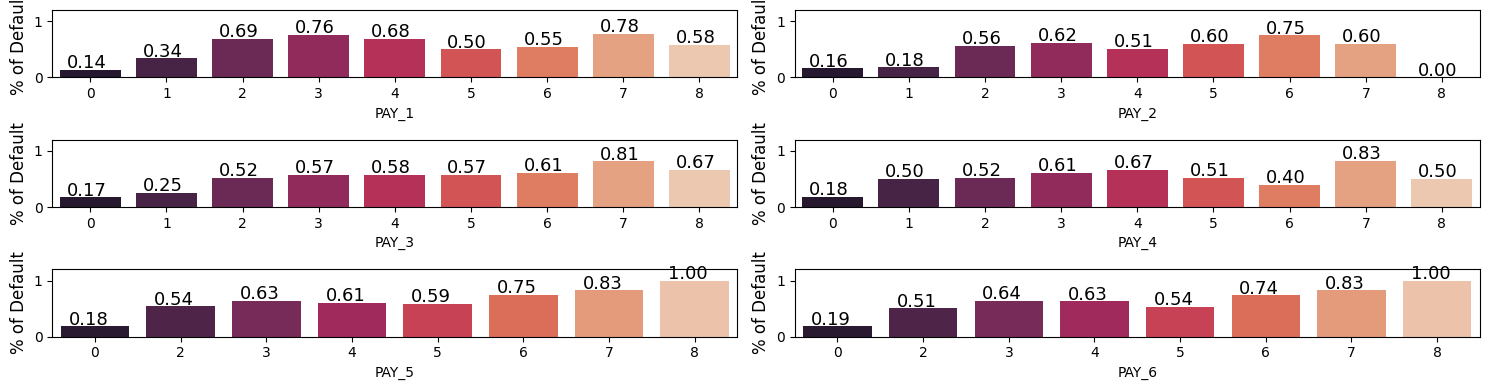

In [57]:
plt.figure(figsize=(15,4))

for i,col in enumerate(pay_x_fts):
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "def_pay", data = df, palette = 'rocket', errorbar = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,1.2)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.09, p.get_height()+0.03),fontsize=13)

plt.show()

> -> Credit card holders who consistently delay their payments for more than 3 months are significantly more likely to face defaults.

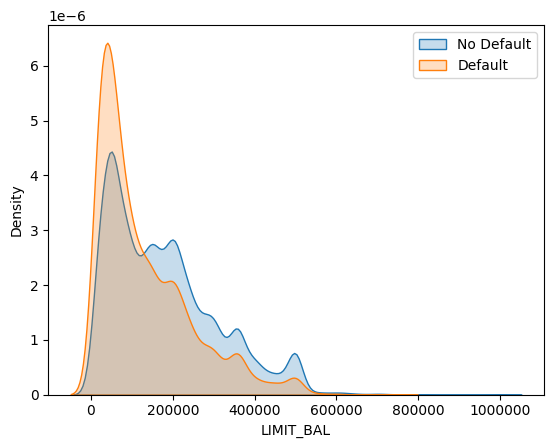

In [58]:
#Limit Bal
sns.kdeplot(df.loc[(df['def_pay'] == 0), 'LIMIT_BAL'], label = 'No Default', fill = True)
sns.kdeplot(df.loc[(df['def_pay'] == 1), 'LIMIT_BAL'], label = 'Default', fill = True)
plt.ticklabel_format(style='plain', axis='x')
plt.legend()
plt.show()

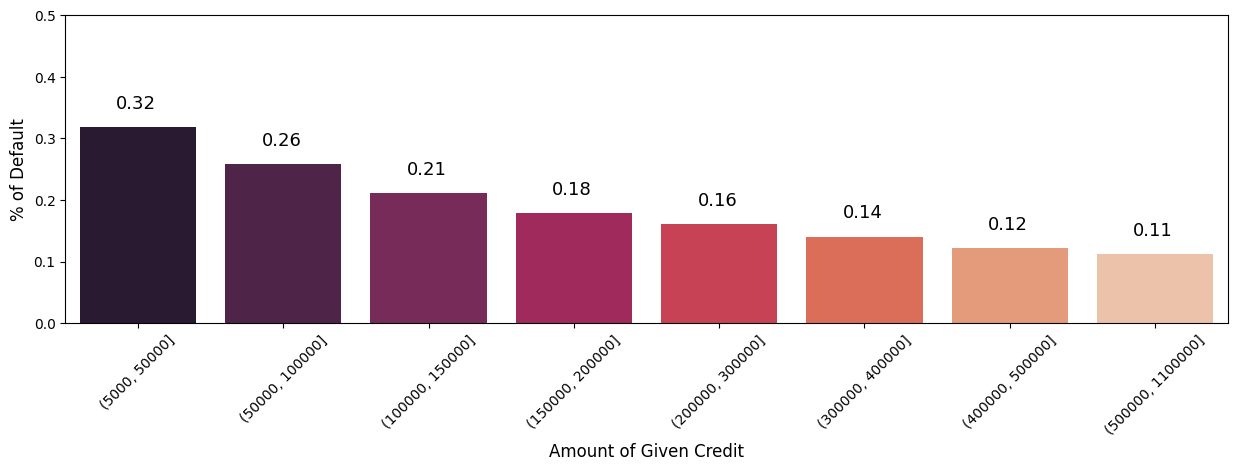

In [59]:
data=df.copy()
data['LimitBin'] = pd.cut(df['LIMIT_BAL'],[5000, 50000, 100000, 150000, 200000, 300000, 400000, 500000, 1100000])
LimitBin_order = ['(5000, 50000]', '(50000, 100000]', '(100000, 150000]', '(150000, 200000]',
                '(200000, 300000]', '(300000, 400000]', '(400000, 500000]', '(500000, 1100000]']
plt.figure(figsize=(15,4))
ax = sns.barplot(x = "LimitBin", y = "def_pay", data = data, palette = 'rocket', errorbar = None, order = LimitBin_order)
plt.xticks(rotation=45)

plt.xlabel("Amount of Given Credit", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

> There is a significant rate of default (over 30%) from customers with 50k or less of credit limit. 

> Nearly 60 percent of defaulters have lower credit limits, specifically under 100k NT dollars.

> The higher the limit, the lower is the chance of defaulting.

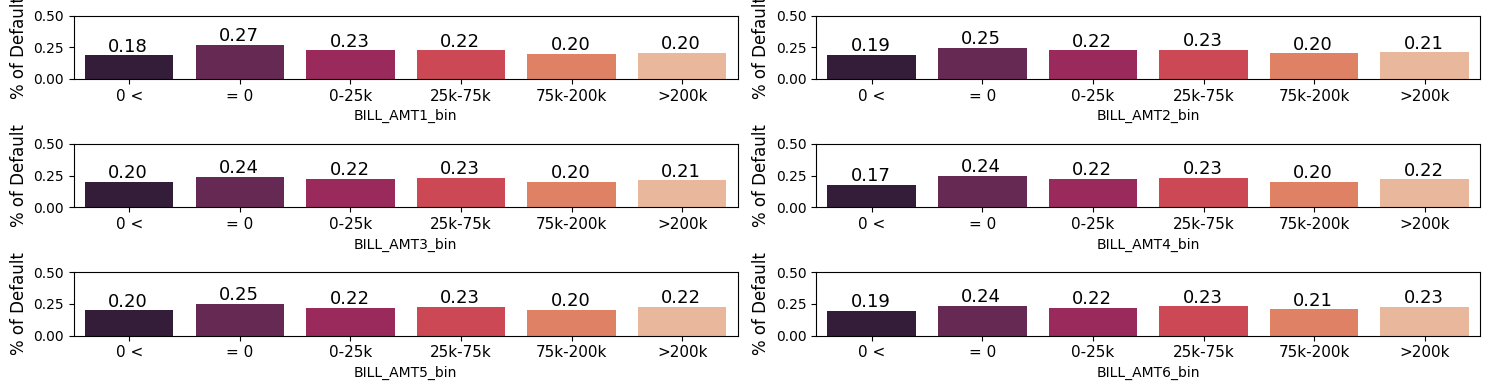

In [60]:
#BILL_AMTX (Discretisation)
bill_amtx_fts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
bill_amtx_bins = ['BILL_AMT1_bin', 'BILL_AMT2_bin', 'BILL_AMT3_bin', 'BILL_AMT4_bin', 'BILL_AMT5_bin', 'BILL_AMT6_bin']
for i, col in enumerate (bill_amtx_bins):
    data[col] = pd.cut(df[bill_amtx_fts[i]],[-350000,-1,0,25000, 75000, 200000, 2000000])
plt.figure(figsize=(15,4))

for i,col in enumerate(bill_amtx_bins):
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "def_pay", data = data, palette = 'rocket', errorbar = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,0.5)
    plt.xticks([0,1,2,3,4,5],['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize = 11)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.21, p.get_height()+0.03),fontsize=13)

plt.show()

> ->  Those who have a negative bill statement have a lower chance of default than the rest. What stands out is that there is a little higher chance of default for those who didn't have a bill in the previous months.

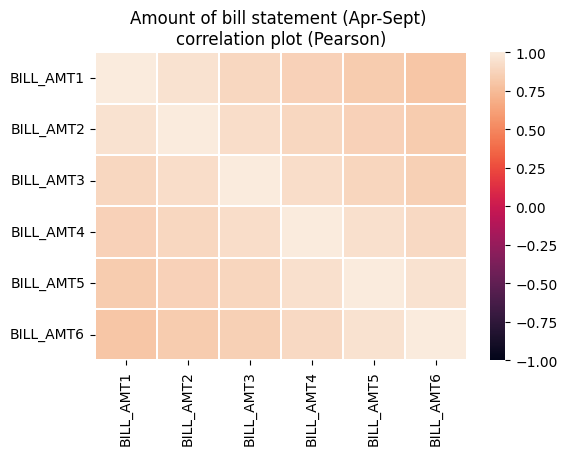

In [61]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize = (6,4))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

> Bill_AMT variables are highly correlated, as the Bill_AMT depends on previous money owned plus money drawn present month due to which it has strong correlation with previous month Bill_AMT.

> Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


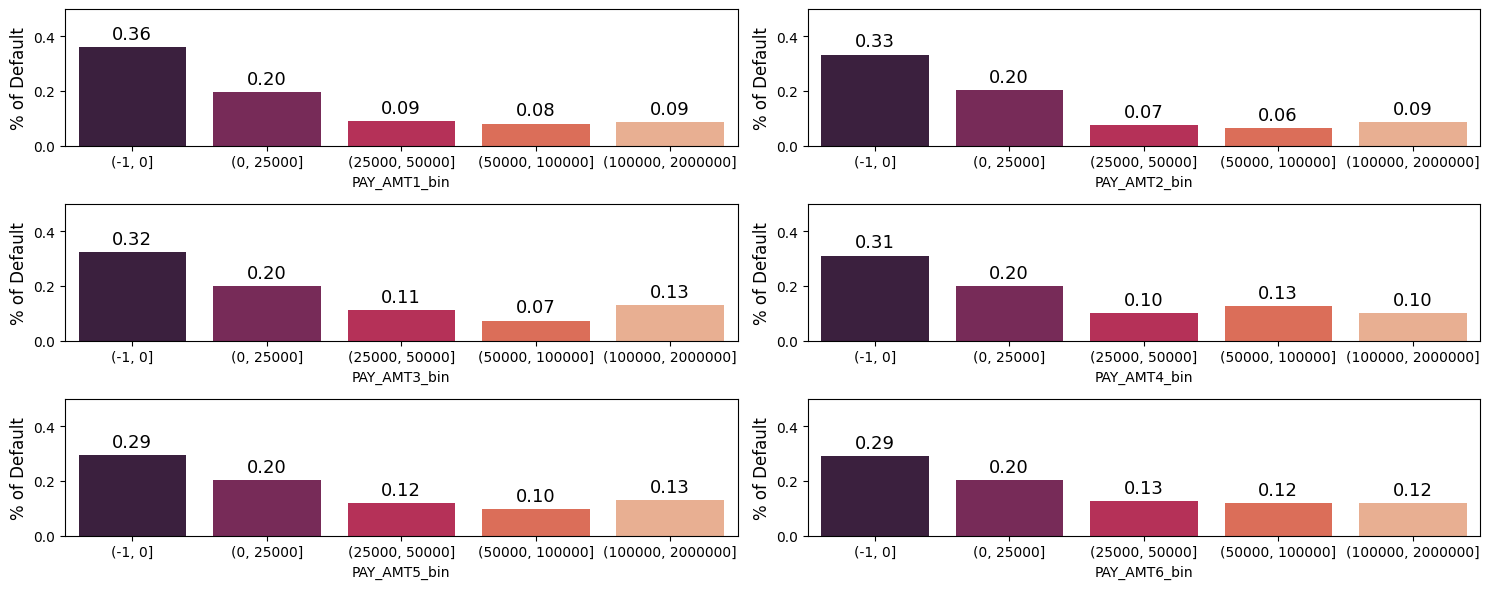

In [62]:
#PAY_AMTX (Discretisation)
pay_amtx_fts = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
pay_amtx_bins = ['PAY_AMT1_bin', 'PAY_AMT2_bin', 'PAY_AMT3_bin', 'PAY_AMT4_bin', 'PAY_AMT5_bin', 'PAY_AMT6_bin']

for i, col in enumerate (pay_amtx_bins):
    data[col] = pd.cut(df[pay_amtx_fts[i]],[-1, 0, 25000, 50000, 100000, 2000000])

plt.figure(figsize=(15,6))

for i,col in enumerate(pay_amtx_bins):
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x = col, y = "def_pay", data = data, palette = 'rocket', errorbar = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,0.5)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

>  -> There is a higher default rate among those who paid nothing in previous months and lower rates among those paid over 25k of NT dollars.

# **Statistical Hypothesis Testing**

### Chi Independency Test 
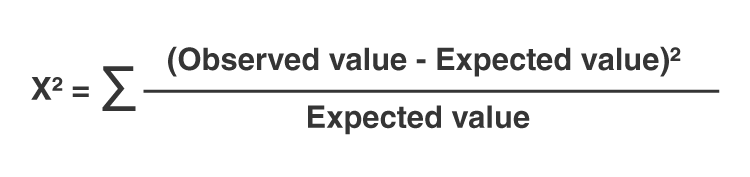

Ho: Variables are independent

H1: Variables are dependent

In [63]:
variables = ['SEX', 'EDUCATION', 'MARRIAGE']

for var in variables:
    # Construction de la table de contingence
    contingency_table = df.groupby(var)['def_pay'].value_counts().unstack().fillna(0)
    contingency_table.columns = ['Non-defaulter', 'Defaulter']
    
    # Test du Chi-deux
    stat, p, dof, _ = chi2_contingency(contingency_table)
    
    # Interprétation
    alpha = 0.05
    print(f"Variable: {var}")
    print(f"Chi-square stat: {stat:.3f}, p-value: {p:.3f}")
    print("Dependent (reject H0)" if p <= alpha else "Independent (fail to reject H0)")
    print("-" * 50)

Variable: SEX
Chi-square stat: 47.709, p-value: 0.000
Dependent (reject H0)
--------------------------------------------------
Variable: EDUCATION
Chi-square stat: 160.410, p-value: 0.000
Dependent (reject H0)
--------------------------------------------------
Variable: MARRIAGE
Chi-square stat: 28.130, p-value: 0.000
Dependent (reject H0)
--------------------------------------------------


> The results of chi independence test indicate that the categorical variables and target variables are dependent.

### Cramér's V Test


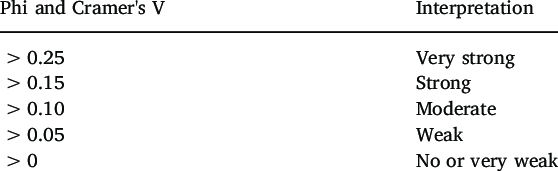

Cramér's V is a statistical test used to measure the strength of association between two categorical variables. It is based on the Chi-Square test but provides a normalized value between 0 and 1, making it easier to interpret.

In [64]:
cols=["SEX","EDUCATION","MARRIAGE","PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
data = df[cols]
n = len(data)
df_cramer = pd.DataFrame(index=cols, columns=cols)

for i in range(len(cols)):
        for j in range(len(cols)):
            if i != j:
                crosstab = pd.crosstab(data[cols[i]], data[cols[j]])
                chi2, _, _, _ = chi2_contingency(crosstab)
                v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
                df_cramer.at[cols[i], cols[j]] = v
print("Cramer's V for each pair of variables:")
print(df_cramer)

Cramer's V for each pair of variables:
                SEX EDUCATION  MARRIAGE     PAY_1     PAY_2     PAY_3  \
SEX             NaN  0.028234  0.031022  0.039891  0.047793   0.04675   
EDUCATION  0.028234       NaN  0.134693  0.052015  0.057535   0.05315   
MARRIAGE   0.031022  0.134693       NaN  0.018885  0.015714  0.014071   
PAY_1      0.039891  0.052015  0.018885       NaN  0.614406  0.465045   
PAY_2      0.047793  0.057535  0.015714  0.614406       NaN   0.57544   
PAY_3       0.04675   0.05315  0.014071  0.465045   0.57544       NaN   
PAY_4      0.045851  0.050263  0.013758  0.345769  0.415846  0.571104   
PAY_5      0.042721  0.044646  0.010984  0.264553  0.284481  0.455034   
PAY_6      0.035754  0.039547   0.00972  0.203885  0.209398  0.366392   

              PAY_4     PAY_5     PAY_6  
SEX        0.045851  0.042721  0.035754  
EDUCATION  0.050263  0.044646  0.039547  
MARRIAGE   0.013758  0.010984   0.00972  
PAY_1      0.345769  0.264553  0.203885  
PAY_2      0.415846 

> Weak Association Between Demographic Variables (SEX, EDUCATION, MARRIAGE) and Payment History (PAY_X)

> Strong Association Between Payment History Variables (PAY_1 to PAY_6)

> Moderate Association Between EDUCATION and MARRIAGE (V = 0.13)

# **Data Preprocessing**

In [65]:
# Séparer la variable cible
y = df['def_pay']
X = df.drop(columns=['def_pay'])

# Encodage One-Hot des variables catégorielles
X = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE'], dtype=int, drop_first=True)

# Normalisation des variables numériques
scaler = StandardScaler()
X[X.select_dtypes(include=['int64', 'float64']).columns] = scaler.fit_transform(X.select_dtypes(include=['int64', 'float64']))

print(X.head())

   LIMIT_BAL       AGE     PAY_1     PAY_2     PAY_3    PAY_4     PAY_5  \
0  -1.136720 -1.246020  2.160496  2.095469 -0.384614 -0.33999 -0.308621   
1  -0.365981 -1.029047 -0.469071  2.095469 -0.384614 -0.33999 -0.308621   
2  -0.597202 -0.161156 -0.469071 -0.399186 -0.384614 -0.33999 -0.308621   
3  -0.905498  0.164303 -0.469071 -0.399186 -0.384614 -0.33999 -0.308621   
4  -0.905498  2.334029 -0.469071 -0.399186 -0.384614 -0.33999 -0.308621   

      PAY_6  BILL_AMT1  BILL_AMT2  ...  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0 -0.316688  -0.642501  -0.647399  ... -0.296801 -0.308063 -0.314136   
1  2.478850  -0.659219  -0.666747  ... -0.240005 -0.244230 -0.314136   
2 -0.316688  -0.298560  -0.493899  ... -0.240005 -0.244230 -0.248683   
3 -0.316688  -0.057491  -0.013293  ... -0.228645 -0.237846 -0.244166   
4 -0.316688  -0.578618  -0.611318  ...  0.271165  0.266434 -0.269039   

   PAY_AMT6  SEX_2  EDUCATION_2  EDUCATION_3  EDUCATION_4  MARRIAGE_2  \
0 -0.293382      1            1            

### Feature Selection

In [66]:
# removing highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)
X = X.drop(columns=to_drop)

['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']


> As we have seen earlier, Bill_AMT variables are highly correlated. We will only keep BILL_AMT1 which conatains the newest BILL.

<Axes: >

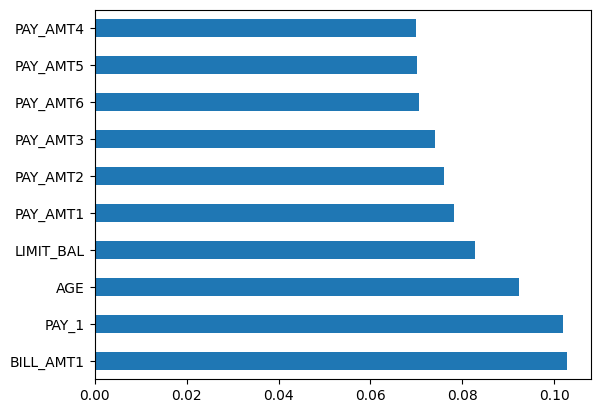

In [67]:
# Compute Feature Importances Using Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh') 

# **Model Building**

In [68]:
list_models = []
list_accur = []
list_gini= []

In [69]:
def conf_mat_show (confusion_matrix) :
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [70]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Dictionnaire pour stocker les résultats
results_accuracy = {model_name: [] for model_name in models.keys()}
results_gini = {model_name: [] for model_name in models.keys()}

In [71]:
for i in range(10):
    print(f"\n🔄 Iteration {i+1}/10\n" + "="*30)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    for model_name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        gini = 2 * roc_auc_score(y_test, y_pred) - 1

        results_accuracy[model_name].append(accuracy)
        results_gini[model_name].append(gini)

        print(f"{model_name}: Accuracy = {accuracy:.4f}, Gini = {gini:.4f}")


🔄 Iteration 1/10
Logistic Regression: Accuracy = 0.8228, Gini = 0.2798
Random Forest: Accuracy = 0.8203, Gini = 0.3124
SVM: Accuracy = 0.8265, Gini = 0.3163
KNN: Accuracy = 0.8008, Gini = 0.2897
XGBoost: Accuracy = 0.8170, Gini = 0.3031
[LightGBM] [Info] Number of positive: 5339, number of negative: 18661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222458 -> initscore=-1.251397
[LightGBM] [Info] Start training from score -1.251397
LightGBM: Accuracy = 0.8272, Gini = 0.3255
Naive Bayes: Accuracy = 0.7663, Gini = 0.3903

🔄 Iteration 2/10
Logistic Regression: Accuracy = 0.8145, Gini = 0.2721
Random Forest: Accuracy = 0.8155, Gini = 0.3

C:\Users\Skouza\AppData\Local\Temp\ipykernel_3992\320848894.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_accuracy.columns, rotation=45)
C:\Users\Skouza\AppData\Local\Temp\ipykernel_3992\320848894.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_gini.columns, rotation=45)


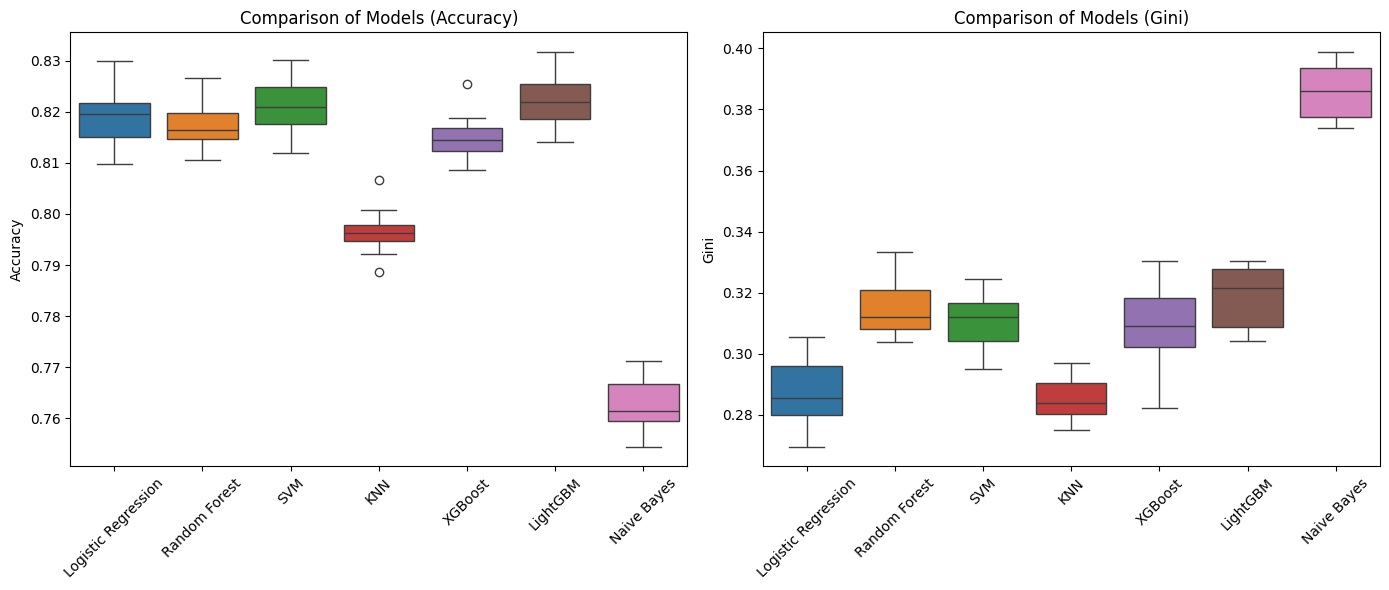

In [74]:
# 🔹 Création des DataFrames pour les boxplots
df_accuracy = pd.DataFrame(results_accuracy)
df_gini = pd.DataFrame(results_gini)

# 🔹 Affichage des boxplots avec subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot Accuracy
sns.boxplot(data=df_accuracy, ax=axes[0])
axes[0].set_title("Comparison of Models (Accuracy)")
axes[0].set_ylabel("Accuracy")
axes[0].set_xticklabels(df_accuracy.columns, rotation=45)

# Boxplot Gini
sns.boxplot(data=df_gini, ax=axes[1])
axes[1].set_title("Comparison of Models (Gini)")
axes[1].set_ylabel("Gini")
axes[1].set_xticklabels(df_gini.columns, rotation=45)

plt.tight_layout()
plt.show()

**Accuracy Comparison:**

> LightGBM and SVM show the highest accuracy, followed by Logistic Regression and Random Forest.

> KNN and Naïve Bayes perform the worst, with Naïve Bayes having the lowest accuracy.



**Gini Comparison:**

> Naïve Bayes has the highest Gini, indicating poor performance in distinguishing between classes.

> NN and Logistic Regression have the lowest Gini, suggesting better class separation.

**Conclusion:**

> LightGBM and SVM are the best performers in terms of accuracy.

> Naïve Bayes performs the worst across both metrics.

> KNN also underperforms, especially in accuracy.

> XGBoost and Random Forest are solid choices, balancing accuracy and Gini.